# On the age and length of a leaf's parent

In this note, we aim to discover approximations that lead to a nice solution for the density of the age and length of a leaf's parent node. 
In particular, we are interested in finding an expression for $f_{age}(t | l)$, i.e. the density of the age of a parent knowing that it lasts over a distance $l$. 

## Simulations 

We sill start by simulating an ARG and collecting information about the age and survival length of the first leaf's parent. 
We will use a recombination rate $\rho=10^{-8}$, and simulate an ARG containing $n_p + 1$ leaves over a distance of $1$ M. 

The ARG is then visited and information about the age and length of the first leaf's parent is recorded.

In [1]:
import msprime 
from tskit import TreeSequence, Tree
import numpy as np

_rec_rate = 1e-8

def simulate_arg(npanel: int, morgans=1.) -> TreeSequence:
    return msprime.simulate(sample_size=npanel + 1, 
                            Ne=1e4, 
                            length=morgans/_rec_rate, 
                            recombination_rate=_rec_rate
                            )



In [2]:
def get_parent(tree: Tree) -> list:
    """
    Returns the indices of the cousins of leave 0 in the tree.
    """
    return tree.parent(0)

def is_k_still_parent(tree: Tree, k: int) -> bool:
    """
    check if k is still a cousin of leave 0 after a tree change
    """
    return tree.parent(0) == k



In [3]:
segment_lengths_cm = []
segment_ages = []
nb_chromosomes = 1

for ii in range(nb_chromosomes):
    npanel = 1000
    ts = simulate_arg(npanel=npanel, morgans=1)
    seg_length = 0
    tree = ts.first()

    parent = get_parent(tree)
    age_parent = tree.tmrca(0, parent)
    for tree in ts.trees():
        if not is_k_still_parent(tree, parent):
            segment_lengths_cm.append(seg_length * _rec_rate * 100) 
            seg_length = 0
            segment_ages.append(age_parent)
            parent = get_parent(tree)
            age_parent = tree.tmrca(0, parent)

        seg_length += (tree.interval.right - tree.interval.left)



The following plots show the densities of the length and age of the parent node, as well a the age in function of the length:

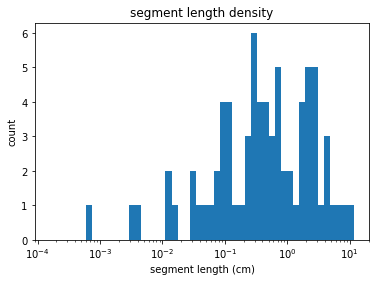

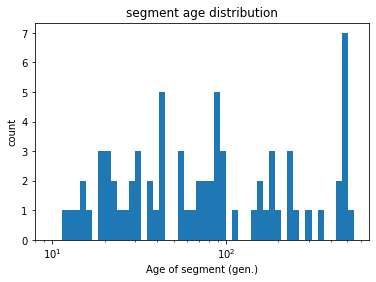

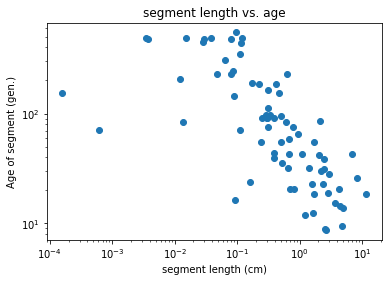

In [4]:
import matplotlib.pyplot as plt

_, bins = np.histogram(segment_lengths_cm, bins=50)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

plt.hist(segment_lengths_cm, bins=logbins)
plt.xlabel('segment length (cm)')
plt.ylabel('count')
plt.title('segment length density')
plt.xscale("log")
plt.show()

_, bins = np.histogram(segment_ages, bins=50)
logbins = np.logspace(np.log10(bins[0]+1),np.log10(bins[-1]),len(bins))

plt.hist(segment_ages, bins=logbins)
plt.xlabel('Age of segment (gen.)')
plt.ylabel('count')
plt.title('segment age distribution')
plt.xscale("log")
plt.show()

plt.scatter(segment_lengths_cm, segment_ages)
plt.xlabel('segment length (cm)')
plt.ylabel('Age of segment (gen.)')
plt.title('segment length vs. age')
plt.xscale("log")
plt.yscale("log")
plt.show()

## IBD model
In the first model, we will assume that the parent node has only two children, and that it ceases to be the first leaf's direct parent if a recombination event breaks the IBD segment. 

In this case, it is easy to show that under a constant coalescent rate $\gamma$, the density is given by an Erlang-3 distribution of scale $\frac{1}{2l + \gamma}$. 

Note that if we consider the possibility of a younger parent to appear without the IBD segment to be broken, thus considering the age of segments of length at least $l$, the density is given by an Erlang-2 distribution of scale $\frac{1}{2l + \gamma}$.

The next plot shows how these two distributions fit the generated data:

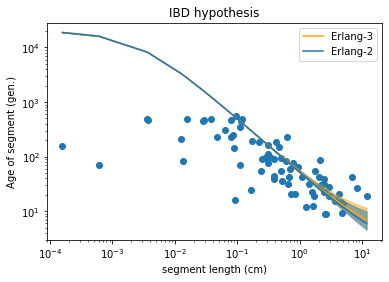

In [5]:
import scipy.stats 
from numpy import exp
from scipy.integrate import quad

gamma = 1./20_000

def age_given_length_ibd(length_m: float, quantile: float) -> float:
    """
    Returns the age of an IBD segment of length lenght_m.
    """
    return scipy.stats.erlang.ppf(quantile, 3,  1 / (2 * length_m + gamma))


def age_given_minlength_ibd(length_m: float, quantile: float) -> float:
    """
    Returns the age of an IBD segment of length lenght_m.
    """
    return scipy.stats.erlang.ppf(quantile, 2,  1 / (2 * length_m + gamma))

plt.scatter(segment_lengths_cm, segment_ages)

plt.plot(np.sort(segment_lengths_cm), age_given_length_ibd(np.sort(np.array(segment_lengths_cm)/100), quantile=0.5), color="orange", label="Erlang-3" )
plt.fill_between(np.sort(segment_lengths_cm), age_given_length_ibd(np.sort(np.array(segment_lengths_cm)/100), quantile=0.025),age_given_length_ibd(np.sort(np.array(segment_lengths_cm)/100), quantile=0.975), color="orange", alpha=0.5)

plt.plot(np.sort(segment_lengths_cm), age_given_minlength_ibd(np.sort(np.array(segment_lengths_cm)/100), quantile=0.5), color="tab:blue", label="Erlang-2" )
plt.fill_between(np.sort(segment_lengths_cm), age_given_minlength_ibd(np.sort(np.array(segment_lengths_cm)/100), quantile=0.025),age_given_minlength_ibd(np.sort(np.array(segment_lengths_cm)/100), quantile=0.975), color="tab:blue", alpha=0.5)

plt.legend()
plt.title("IBD hypothesis")
plt.yscale("log")
plt.xscale("log")

plt.xlabel("segment length (cm)")
plt.ylabel("Age of segment (gen.)")
plt.show()


These two models are quite accurate for long and recent segments, where it is unlikely that a recombination event coalesces under it.
However, they completely overestimate the age of short and older segments, as well as dramatically underestimating the variance. 
A reason for this is that we ignored the condition that the IBD segment is the youngest involving leaf 1.  

## The open-tree model
Another model leads to closed-form solutions. 
We again impose that the parent of the first leaf has only two children. 
This time, we also further impose that the rest of the ARG can not coalesce before the age $t$ of the parent.  
Under this assumption, the first coalescent event involving the first leaf at any given site follows an exponential distribution:
$$f_{site}(t)= n_{p}\gamma_0e^{- n_{p}\gamma_0 t}$$
<!-- -->
Under the SMC approximation, this node will last until one of the following events happen:

1. A recombination event happens on the lineages under the parent, with rate $2t$ 
2. A recombination event happens on the rest of the tree, and recombines between the first leaf and its parent, with rate $\mu(t)$ 
<!-- -->
Assuming $\mu(t)$ is known, the length the segment spanning the parent of the first leaf at a random site, conditionned on the age of the parent being $t$, is given by:
<!-- -->
$$
f_{site}(l|t) = (2t+\mu(t))^2 l~e^{-(2t + \mu(t))l}
$$
<!-- -->
By marginalising the time, we get:
$$
f_{site}(l) = \int\limits_0^\infty f_{site}(l|t)f_{site}(t) dt
$$
<!-- -->
We can get the densities of the segments from the previous expression:
<!-- -->
$$
f_{seg}(l) = \frac{1}{Z} \frac{f_{site}(l)}{l}
$$
<!-- -->
To derive $f_{age}(t |l)$, we note that it represents the age of the parent at randomly selected site spanned by an segment of length $l$, and get:
$$
f_{age}(t |l) = \frac{f_{site}(l | t)f_{site}(t)}{f_{site}(l)}
$$


Deriving $\mu(t)$ under the "open side-tree" hypothesis is similar to computing the probability of healing of the SMC' framework. 
<!-- -->
First, we know that onl recombination events happening on the $n_p-1$ lineages of the open tree between 0 and $t$ can lead to a change of the parent node, thus:
$$\mu(t)\propto (n_p-1) t$$
<!-- -->
Furthermore, once this recombination event happen, it must hit the first lineage between time $V$ when the recombination event happens and $t$:
$$
p_{hit}(t) = \frac{1}{n_p +1} \frac{1}{t} \int\limits_0^t \frac{\int\limits_v^t f_{coal}(w;n_p+2)dw}{1-\int\limits_0^vf_{coal}(w;n_p+2)dw}dv
$$
<!-- -->
For a constant population size, this formula becomes:
$$p_{hit}(t)=\frac{t-\frac{1-e^{-(\gamma  (n_p+2) t)}}{\gamma  (n_p+2)}}{(n_p+1) t}$$
<!-- -->
This leads to:
$$\mu(t) = \frac{n_p-1}{n_p+1} (t-\frac{1-e^{-(\gamma  (n_p+2) t)}}{\gamma  (n_p+2)}) \approx 2t + \mathcal{O}(\gamma n_p)$$


The following plot shows how this model, and the approximation $\mu(t)\approx 2t$ fits the generated data:

In [6]:

def age_given_min_length_2tapprox(length_m: float, quantile: float) -> float:
    """
    Returns the age of a the node segment assumin mu(t) = 2t
    """
    return scipy.stats.erlang.ppf(quantile, 3, 1 / (4 * length_m + npanel*gamma))

def mu(t, n=npanel):
    return (n - 1) / (n + 1) * (t - (1 - exp(-t * gamma * (n+2))) / (gamma *(n+2)))

def f_l_given_t(l, t, n=npanel):
    return l * (2*t + mu(t, n))**2 * exp(-(2*t + mu(t,n))*l)

def f_coal(t, n=npanel):
    return n * gamma * exp(-n*gamma*t)

def f_t_given_l_notnormalized(t, l, n=npanel):
    return f_l_given_t(l, t, n) * f_coal(t, n)

def f_t_given_l(t, l, n):
    return f_t_given_l_notnormalized(t, l, n) / quad(lambda x: f_t_given_l_notnormalized(x, l, n), 0, np.inf)[0]

def f_t_given_l_quantiles(l, q, n=npanel):
    times = np.linspace(0, 1e6, int(1e6))
    age_density = f_t_given_l_notnormalized(times, l, n)
    age_density /= np.sum(age_density)
    argument = np.argmin(np.cumsum(age_density) < q)
    return times[argument]


In [7]:
mid, up, low = np.zeros(len(segment_lengths_cm)), np.zeros(len(segment_lengths_cm)), np.zeros(len(segment_lengths_cm))

for ii, l in enumerate(np.sort(segment_lengths_cm)):
    n = npanel
    mid[ii] = f_t_given_l_quantiles(l/100, 0.5, n)
    up[ii] = f_t_given_l_quantiles(l/100, 0.975, n)
    low[ii] = f_t_given_l_quantiles(l/100, 0.025, n)

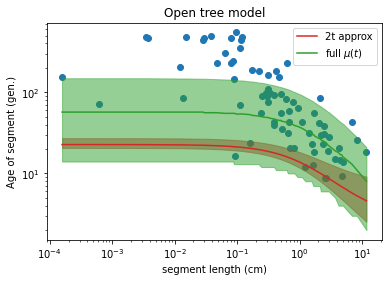

In [8]:
plt.scatter(segment_lengths_cm, segment_ages)

plt.plot(np.sort(segment_lengths_cm), 
        age_given_min_length_2tapprox(np.sort(np.array(segment_lengths_cm)/100), quantile=0.5), 
        color="tab:red", label="2t approx"
        )

plt.fill_between(np.sort(segment_lengths_cm), 
                age_given_min_length_2tapprox(np.sort(np.array(segment_lengths_cm)/100), quantile=0.025),
                age_given_min_length_2tapprox(np.sort(np.array(segment_lengths_cm)/100), quantile=0.975),
                color="tab:red", alpha=0.5)



plt.plot(np.sort(segment_lengths_cm), mid , color="tab:green", label="full $\mu(t)$")
plt.fill_between(np.sort(segment_lengths_cm), low, up , color="tab:green", alpha=0.5)


plt.xlabel('segment length (cm)')
plt.ylabel('Age of segment (gen.)')
plt.title('Open tree model')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

The full $\mu(t)$ model works remarkably well in the recent past, where not many coalescent event affect the rest of the ARG. 

The coalescent rate is however too high for smaller segments, as we would expect when fewer lineages are present in the ARG.


# The fixed-time model

We will improve upon the last model by considering a model where the side tree coalesces at fixed times, given either by the median or mean of the exponential distributions they are following.  

The only difference between this model and the previous one is that $n_p\gamma$ becomes $n(t)\gamma$, with $n(t)$ the number of lineages left at time $t$.

We define $\Delta_n$ the time during which there are $n$ remaining lineages in the panel, and will work with
$\mathbb{E}[\Delta_n] = \frac{2}{\gamma n (n-1)}$ instead of full distributions. 

We will also define $T_i = \sum\limits_{k=i}^n \mathbb{E}[\Delta_k]$ the expected time of the coalescent event ending the region with $n$ lineages.

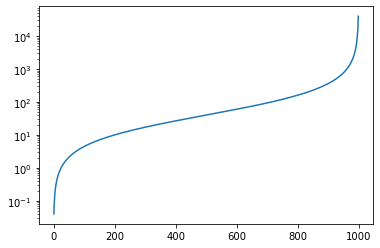

In [9]:
ns = np.arange(2, npanel+1)[::-1]
delta_n = 2 / gamma / ns / (ns - 1)
times = np.cumsum(delta_n)
plt.plot(times)
plt.yscale("log")


We will start by a simplistic and heuristic approach, where will:
1. Compute the median age of the segment as done in the previous model (open-tree)
2. See how many segments have left at this time in our model
3. Compute the median and 95% CI assuming that the panel has the original sinal minus the lineages that have left



In [10]:
mid, up, low = np.zeros(len(segment_lengths_cm)), np.zeros(len(segment_lengths_cm)), np.zeros(len(segment_lengths_cm))
mid2it, up2it, low2it = np.zeros(len(segment_lengths_cm)), np.zeros(len(segment_lengths_cm)), np.zeros(len(segment_lengths_cm))

for ii, l in enumerate(np.sort(segment_lengths_cm)):
    n = npanel
    mid[ii] = f_t_given_l_quantiles(l/100, 0.5, n)
    n = npanel - np.argmin(times < mid[ii])
    mid[ii] = f_t_given_l_quantiles(l/100, 0.5, n)
    up[ii] = f_t_given_l_quantiles(l/100, 0.975, n)
    low[ii] = f_t_given_l_quantiles(l/100, 0.025, n)
    n = npanel - np.argmin(times < mid[ii])
    mid2it[ii] = f_t_given_l_quantiles(l/100, 0.5, n)
    up2it[ii] = f_t_given_l_quantiles(l/100, 0.975, n)
    low2it[ii] = f_t_given_l_quantiles(l/100, 0.025, n)

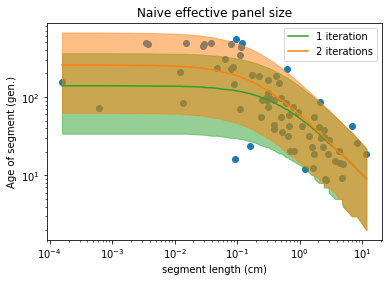

In [12]:
plt.scatter(segment_lengths_cm, segment_ages)

plt.plot(np.sort(segment_lengths_cm), mid , color="tab:green", label="1 iteration")
plt.fill_between(np.sort(segment_lengths_cm), low, up , color="tab:green", alpha=0.5)

plt.plot(np.sort(segment_lengths_cm), mid2it , color="tab:orange", label="2 iterations")
plt.fill_between(np.sort(segment_lengths_cm), low2it, up2it , color="tab:orange", alpha=0.5)

plt.xlabel('segment length (cm)')
plt.ylabel('Age of segment (gen.)')
plt.title('Naive effective panel size')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

If we want more accurate, we can integrate everything from the previous model using n(t) instead of np, this will be easy to do when we will implement this under an arbitrary demographic history, since we will need to perform piece-wise integrations anyway... 